In [32]:
# Libraries
suppressPackageStartupMessages({
    library(Seurat)
    #library(patchwork)
    library(dplyr)
    #library(ggplot2)
    #library(sctransform)
    
    
    library(DropletUtils)
    library(SingleCellExperiment)
    library(scater)
    library(Matrix)
    library(scran)
    library(gridExtra)
    #library(tidyverse)
    #library(BiocFileCache)
    #library(rtracklayer)
    #library(AnnotationDbi)
    options(stringsAsFactors = FALSE)
    
})

In [118]:
#rm(sce)
sce <- read10xCounts("data/filtered_gene_bc_matrices/hg19/", col.names = TRUE)
sce

class: SingleCellExperiment 
dim: 32738 2700 
metadata(1): Samples
assays(1): counts
rownames(32738): ENSG00000243485 ENSG00000237613 ... ENSG00000215616
  ENSG00000215611
rowData names(2): ID Symbol
colnames(2700): AAACATACAACCAC-1 AAACATTGAGCTAC-1 ... TTTGCATGAGAGGC-1
  TTTGCATGCCTCAC-1
colData names(2): Sample Barcode
reducedDimNames(0):
altExpNames(0):

In [75]:
# Annotating the rows
#library(scater)
rownames(sce) <- uniquifyFeatureNames(rowData(sce)$ID, rowData(sce)$Symbol)
head(rownames(sce))
head(colnames(sce))

[1] "MIR1302-10"   "FAM138A"      "OR4F5"        "RP11-34P13.7" "RP11-34P13.8"
[6] "AL627309.1"

[1] "AAACATACAACCAC-1" "AAACATTGAGCTAC-1" "AAACATTGATCAGC-1" "AAACCGTGCTTCCG-1"
[5] "AAACCGTGTATGCG-1" "AAACGCACTGGTAC-1"

In [76]:
library(EnsDb.Hsapiens.v75)
location <- mapIds(EnsDb.Hsapiens.v75, keys=rowData(sce)$ID, 
    column="SEQNAME", keytype="GENEID")

In [77]:
rawData<-as.matrix(counts(sce))

In [78]:
diagnostics<-list()

In [79]:
########################################
##### Characteristics of data
########################################
rawData[1:5,1:5]

dim(rawData)

sum(rawData==0)

nrCells<-apply(rawData,1,function (x){sum(x>0)})
min(nrCells)
max(nrCells)
length(nrCells[nrCells<3])
##12775
##27998-12775 = 15223 genes to keep
length(nrCells[nrCells==0])
##10816


nrGenes<-apply(rawData,2,function (x){sum(x>0)})
min(nrGenes)
max(nrGenes)
##min: 85
##max: 6632
length(nrGenes[nrGenes<200])
##7
## 4055-7= 4048 cells to keep

,AAACATACAACCAC-1,AAACATTGAGCTAC-1,AAACATTGATCAGC-1,AAACCGTGCTTCCG-1,AAACCGTGTATGCG-1
MIR1302-10,0,0,0,0,0
FAM138A,0,0,0,0,0
OR4F5,0,0,0,0,0
RP11-34P13.7,0,0,0,0,0
RP11-34P13.8,0,0,0,0,0


[1] 32738  2700

[1] 86105716

[1] 0

[1] 2700

[1] 19024

[1] 16104

[1] 212

[1] 3422

[1] 0

In [80]:
################################################################################
########## QC: CELLS
################################################################################

########################################
########## Calculate metrics
########################################

##### Create object #####
library("scater")
sce<-SingleCellExperiment(list(counts=rawData))
dim(sce)

[1] 32738  2700

In [81]:
##### Get spike inns #####
is.spike <- grepl("^ERCC", rownames(sce))
sum(is.spike)

[1] 10

In [82]:
##### Get mitochondrial genes #####
is.mito <- grepl("^MT-", rownames(sce))
sum(is.mito)

[1] 13

In [84]:
##### Calculate QC metrics #####
### => pData(sce) is created

sce <- addPerCellQC(sce, 
            subsets=list(Mito=grep("^MT-", rownames(sce))))

sce <- addPerFeatureQC(sce)
sce

class: SingleCellExperiment 
dim: 32738 2700 
metadata(0):
assays(1): counts
rownames(32738): MIR1302-10 FAM138A ... AC002321.2 AC002321.1
rowData names(4): mean detected mean detected
colnames(2700): AAACATACAACCAC-1 AAACATTGAGCTAC-1 ... TTTGCATGAGAGGC-1
  TTTGCATGCCTCAC-1
colData names(12): sum detected ... subsets_Mito_percent total
reducedDimNames(0):
altExpNames(0):

In [85]:
##### Create metaData matrix #####
metaData<-data.frame("staticNr"=colnames(rawData),"nGene"=sce$detected,"nUMI"=sce$total,"percent.mito"=sce$subsets_Mito_percent, 
                     stringsAsFactors = F)
rownames(metaData)<-metaData$staticNr
metaData$staticNr<-1

In [93]:
########################################
########## Get outliers
########################################

##### Aim: remove cells with low library sizes, low numbers of expressed features and with high mitochondrial proportions
##same as nGene in Seurat pipeline
feature.drop <- isOutlier(sce$detected, nmads=4, type="lower", log=TRUE)
sum(feature.drop)

[1] 21

In [92]:
##same as UMI in Seurat pipeline
libsize.drop <- isOutlier(sce$total, nmads=4, type="lower", log=TRUE)
sum(libsize.drop)

[1] 7

In [94]:
mito.drop <- isOutlier(sce$subsets_Mito_percent, nmads=4, type="higher")
sum(mito.drop)

[1] 50

In [95]:
##### add to metaData matrix #####
metaData$nGene.drop=feature.drop
metaData$nUMI.drop=libsize.drop
metaData$mito.drop=mito.drop
metaData$final.drop=feature.drop | libsize.drop | mito.drop

In [96]:
########################################
########## Remove outliers
########################################
sce <- sce[,!(libsize.drop | feature.drop | mito.drop)]
dim(sce)

[1] 32738  2635

In [130]:
library(scater)
sce <- logNormCounts(sce)
sceNew<-scater::runColDataPCA(sce, scale=T ,ncomponents = 10, outliers=T, name = "PCA_coldata")

Warning message in check_numbers(x, k = k, nu = nu, nv = nv):
"more singular values/vectors requested than available"


ERROR: Error in svd(x, nu = nu, nv = nv): a dimension is zero


In [125]:
reducedDimNames(sce)
#head(reducedDim(sce))

character(0)

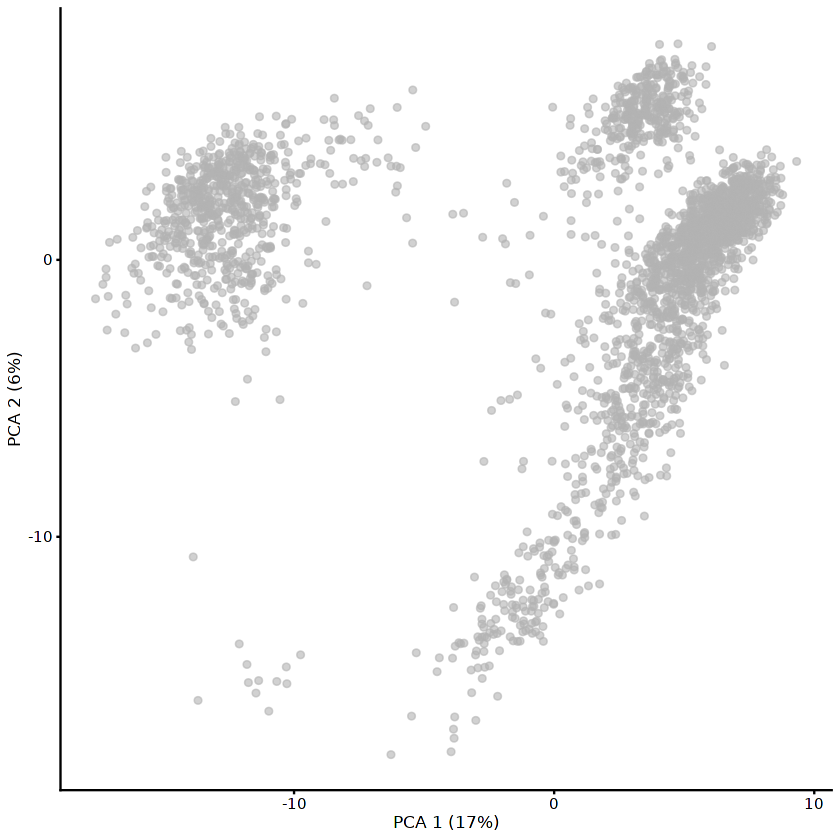

In [133]:
scater::plotPCA(sceNew)

In [132]:
##### Detect bad cells #####
sceNew<-runPCA(sce)



In [ ]:
outs<-colnames(sceNew)[sceNew$outlier]
metaData$pca.drop<-metaData$final.drop
metaData[outs,which(colnames(metaData)=="pca.drop")]<-TRUE

In [98]:
########################################
########## Create PCA
########################################
colnames(colData(sce))
##on position 4, 22 and 18
colnames(colData(sce))[colnames(colData(sce))=="log10_total_counts"]<-"log10_total_counts_feature_controls"
colnames(colData(sce))[colnames(colData(sce))=="pct_counts_feature_control"]<-"pct_counts_feature_controls"
colnames(colData(sce))[colnames(colData(sce))=="total_features_feature_control"]<-"total_features_feature_controls"

[1] "sum"                   "detected"              "subsets_Mito_sum"     
 [4] "subsets_Mito_detected" "subsets_Mito_percent"  "total"                
 [7] "sum"                   "detected"              "subsets_Mito_sum"     
[10] "subsets_Mito_detected" "subsets_Mito_percent"  "total"

In [100]:
png(file="results/plots/3a_pca.png",  width = 850, height = 642)
fontsize <- theme(axis.text=element_text(size=12), axis.title=element_text(size=16))
plotPCA(sce, pca_data_input="pdata", detect_outliers=TRUE) + fontsize
dev.off()

ERROR: Error in value[[3L]](cond): invalid subscript 'type' in 'reducedDim(<SingleCellExperiment>, type="character", ...)':
  'PCA' not in 'reducedDimNames(<SingleCellExperiment>)'


In [97]:
########################################
########## Create violinPlots
########################################

toPlot<-metaData
toPlot<-metaData[! metaData$final.drop,]
toPlot<-metaData[! metaData$pca.drop,]

ERROR: Error in !metaData$pca.drop:  引数の型が不正です 


### Manually

In [46]:
unfiltered <- sce

In [47]:
stats <- perCellQCMetrics(sce, subsets=list(Mito=which(location=="MT")))
high.mito <- isOutlier(stats$subsets_Mito_percent, type="higher")
sce <- sce[,!high.mito]

In [55]:
library(scuttle)
is.mito <- grep("MT", rownames(sce))

per.cell <- perCellQCMetrics(sce, subsets=list(Mito=is.mito))
colnames(per.cell)
per.cell[1:3,]

[1] "sum"                   "detected"              "subsets_Mito_sum"     
[4] "subsets_Mito_detected" "subsets_Mito_percent"  "total"

DataFrame with 3 rows and 6 columns
        sum  detected subsets_Mito_sum subsets_Mito_detected
  <numeric> <integer>        <numeric>             <integer>
1      2421       781               82                    18
2      4903      1352              201                    24
3      3149      1131               44                    19
  subsets_Mito_percent     total
             <numeric> <numeric>
1              3.38703      2421
2              4.09953      4903
3              1.39727      3149

In [56]:

summary(per.cell$sum)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
    561    1792    2221    2399    2774   15844 

In [57]:

summary(per.cell$detected)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  212.0   702.5   822.0   855.8   958.0  3422.0 

In [59]:
summary(per.cell$subsets_Mito_percent)


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3067  1.9612  2.4696  2.5542  3.0522  6.7396 

In [60]:
# There is no spike-in values
summary(per.cell$altexps_ERCC_percent)

Length  Class   Mode 
     0   NULL   NULL 

In [61]:
colData(sce) <- cbind(colData(sce), per.cell)
colnames(colData(sce))

[1] "Sample"                "Barcode"               "sum"                  
[4] "detected"              "subsets_Mito_sum"      "subsets_Mito_detected"
[7] "subsets_Mito_percent"  "total"

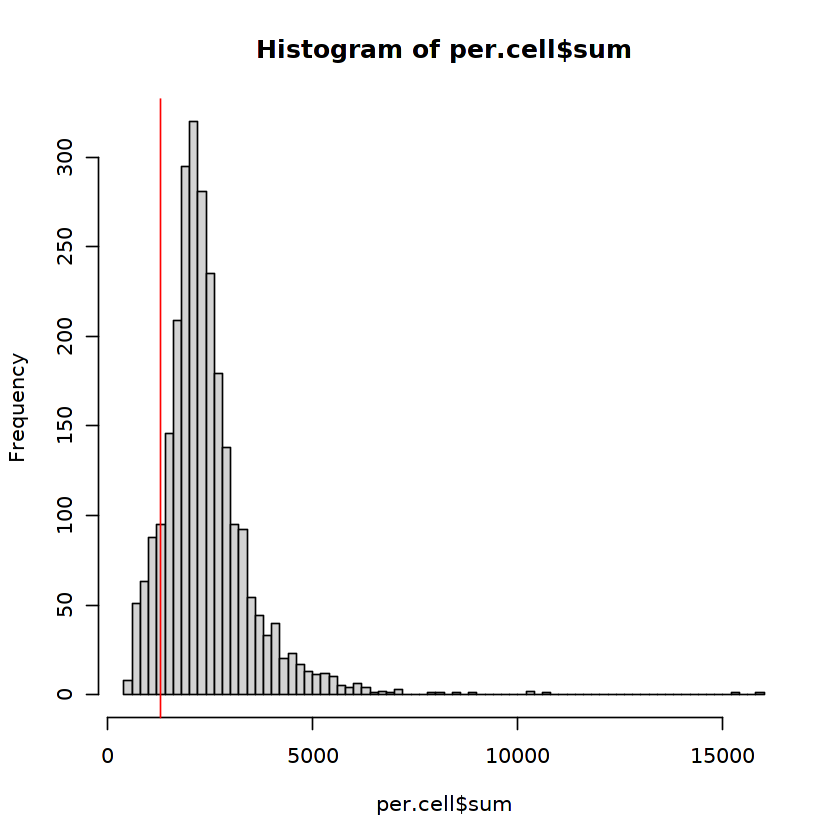

In [65]:
hist(
    per.cell$sum,
    breaks = 100
)
abline(v = 1300, col = "red")

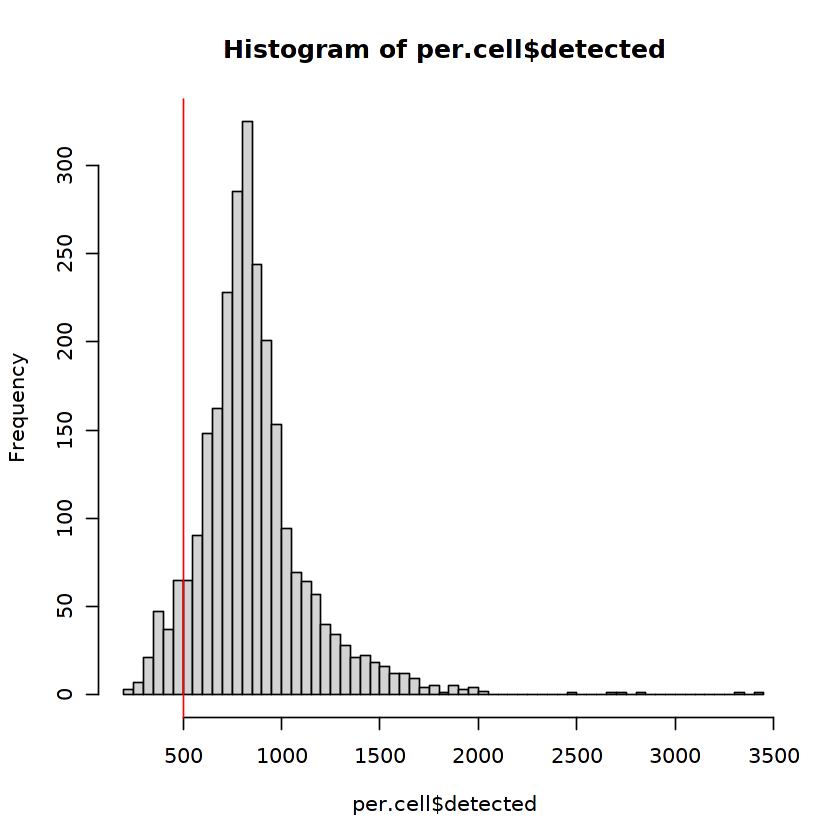

In [70]:
hist(
    per.cell$detected,
    breaks = 100
)
abline(v = 500, col = "red")

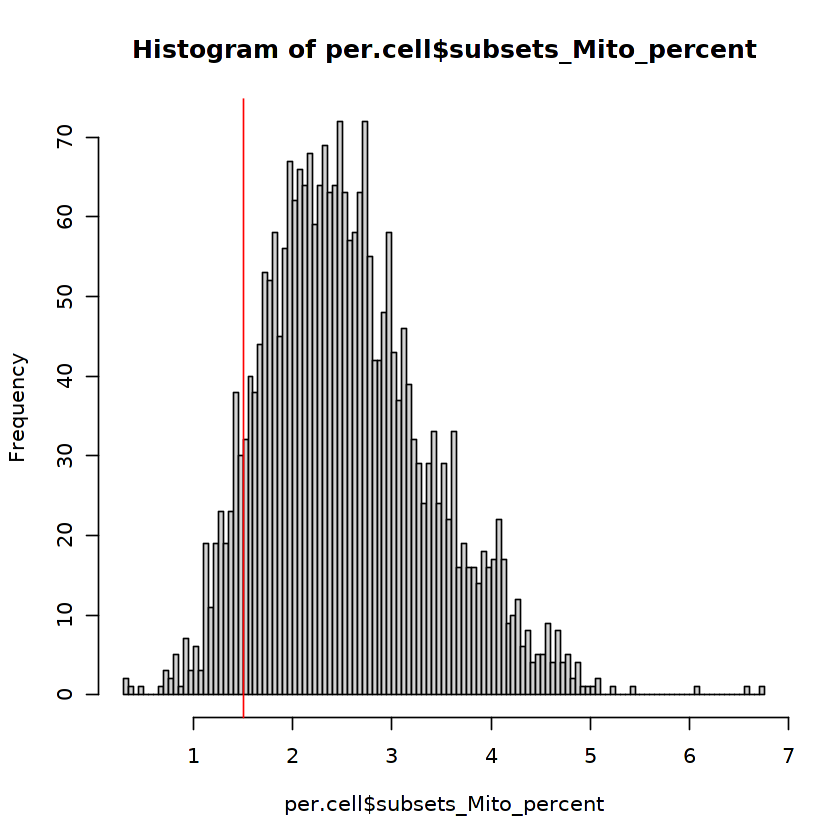

In [68]:
hist(
    per.cell$subsets_Mito_percent,
    breaks = 100
)
abline(v = 1.5, col = "red")

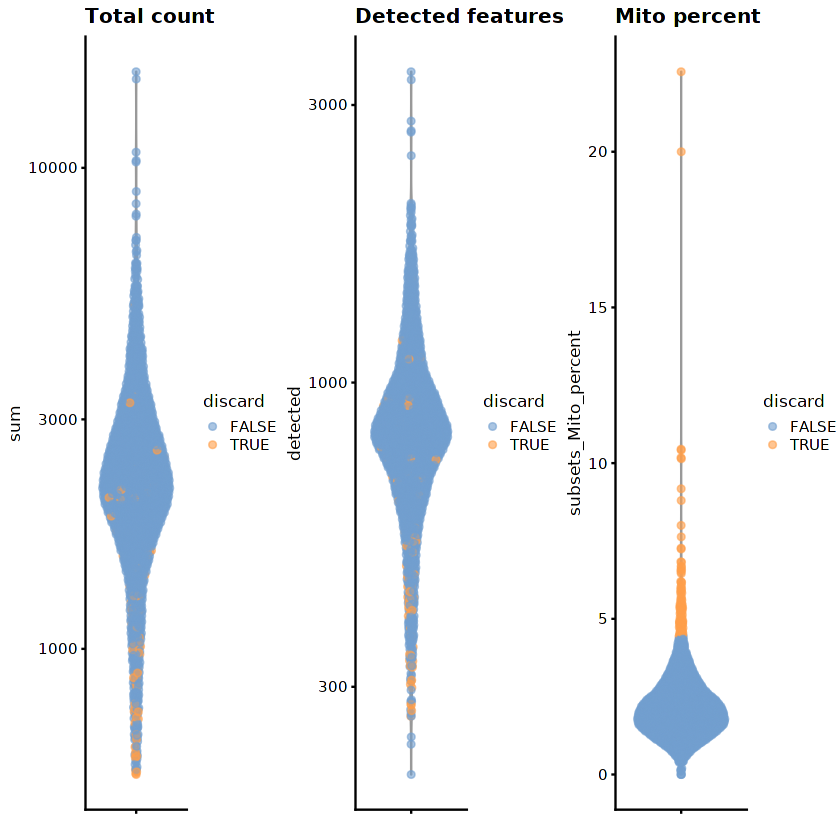

In [72]:
colData(unfiltered) <- cbind(colData(unfiltered), stats)
unfiltered$discard <- high.mito

gridExtra::grid.arrange(
    plotColData(unfiltered, y="sum", colour_by="discard") +
        scale_y_log10() + ggtitle("Total count"),
    plotColData(unfiltered, y="detected", colour_by="discard") +
        scale_y_log10() + ggtitle("Detected features"),
    plotColData(unfiltered, y="subsets_Mito_percent",
        colour_by="discard") + ggtitle("Mito percent"),
    ncol=3
)

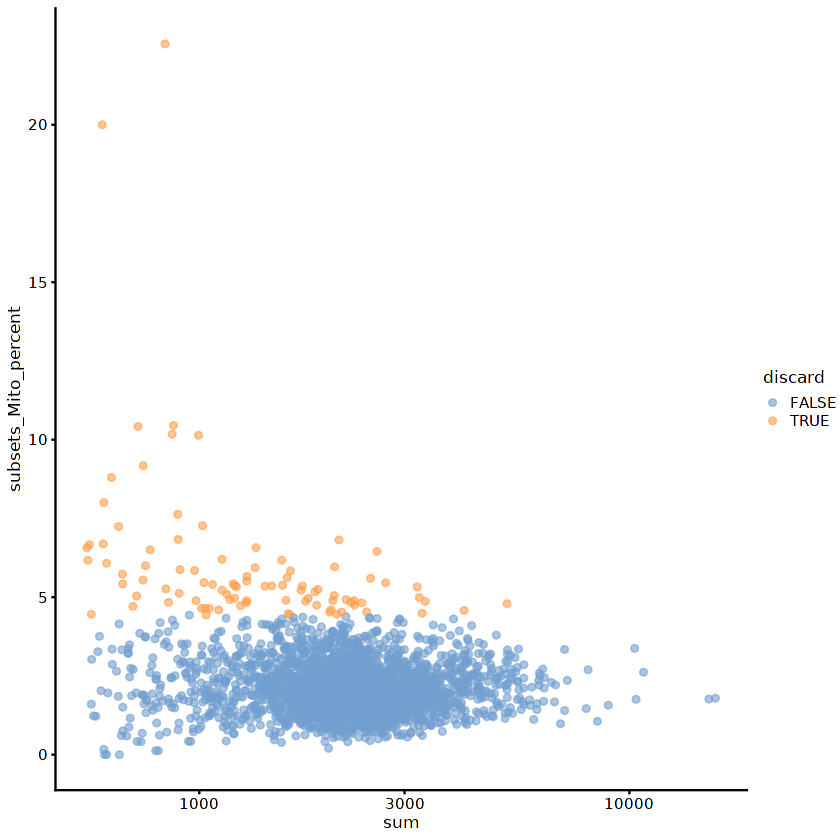

In [73]:
plotColData(unfiltered, x="sum", y="subsets_Mito_percent",
    colour_by="discard") + scale_x_log10()

In [74]:
library(scran)
set.seed(1000)
clusters <- quickCluster(sce)
sce <- computeSumFactors(sce, cluster=clusters)
sce <- logNormCounts(sce)

In [75]:
summary(sizeFactors(sce))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.1477  0.7312  0.9190  1.0000  1.1407  9.0340 

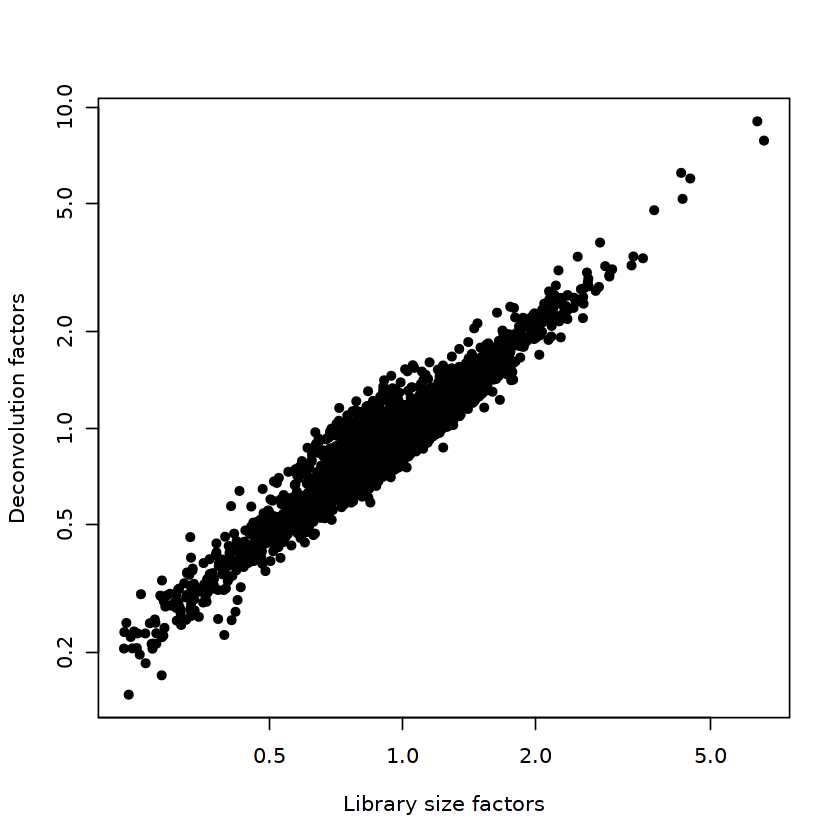

In [76]:
plot(librarySizeFactors(sce), sizeFactors(sce), pch=16,
    xlab="Library size factors", ylab="Deconvolution factors", log="xy")

In [77]:
# Variance modelling
set.seed(1001)
dec.pbmc <- modelGeneVarByPoisson(sce)
top.pbmc <- getTopHVGs(dec.pbmc, prop=0.1)

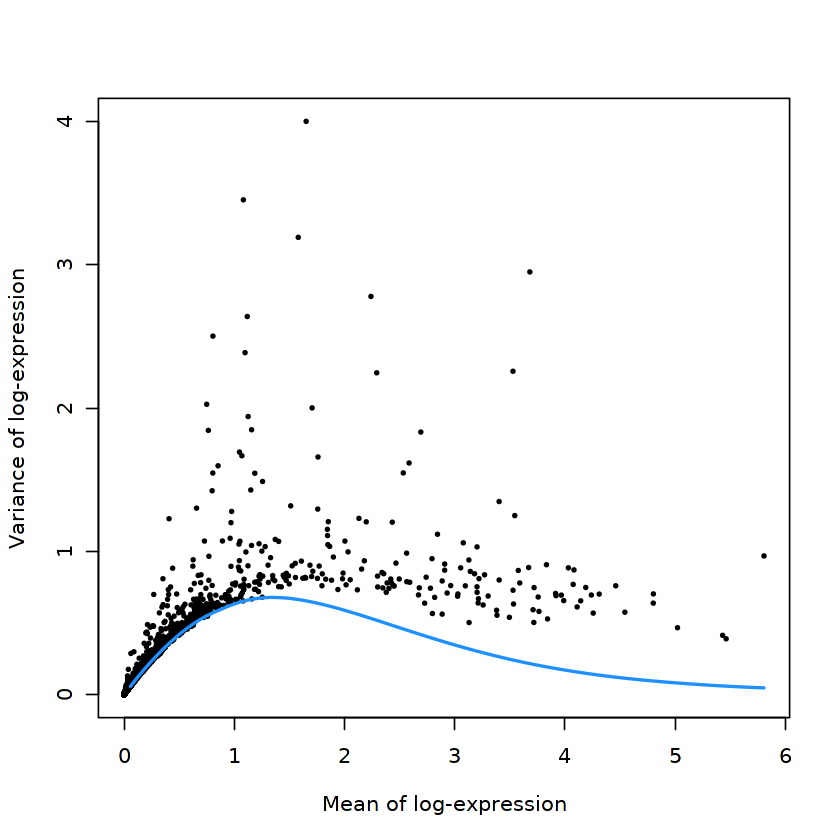

In [78]:
plot(dec.pbmc$mean, dec.pbmc$total, pch=16, cex=0.5,
    xlab="Mean of log-expression", ylab="Variance of log-expression")
curfit <- metadata(dec.pbmc)
curve(curfit$trend(x), col='dodgerblue', add=TRUE, lwd=2)

In [80]:
# Dimensionality reduction

set.seed(10000)
sce <- denoisePCA(sce, subset.row=top.pbmc, technical=dec.pbmc)

set.seed(100000)
sce <- runTSNE(sce, dimred="PCA")

set.seed(1000000)
sce <- runUMAP(sce, dimred="PCA")

In [81]:
ncol(reducedDim(sce, "PCA"))

[1] 21

In [83]:
g <- buildSNNGraph(sce, k=10, use.dimred = 'PCA')
clust <- igraph::cluster_walktrap(g)$membership
colLabels(sce) <- factor(clust)

In [85]:
table(colLabels(sce))


  1   2   3   4   5   6   7   8   9  10  11  12 
199 417 669 162 308 167 168 339  28 128  11  11 

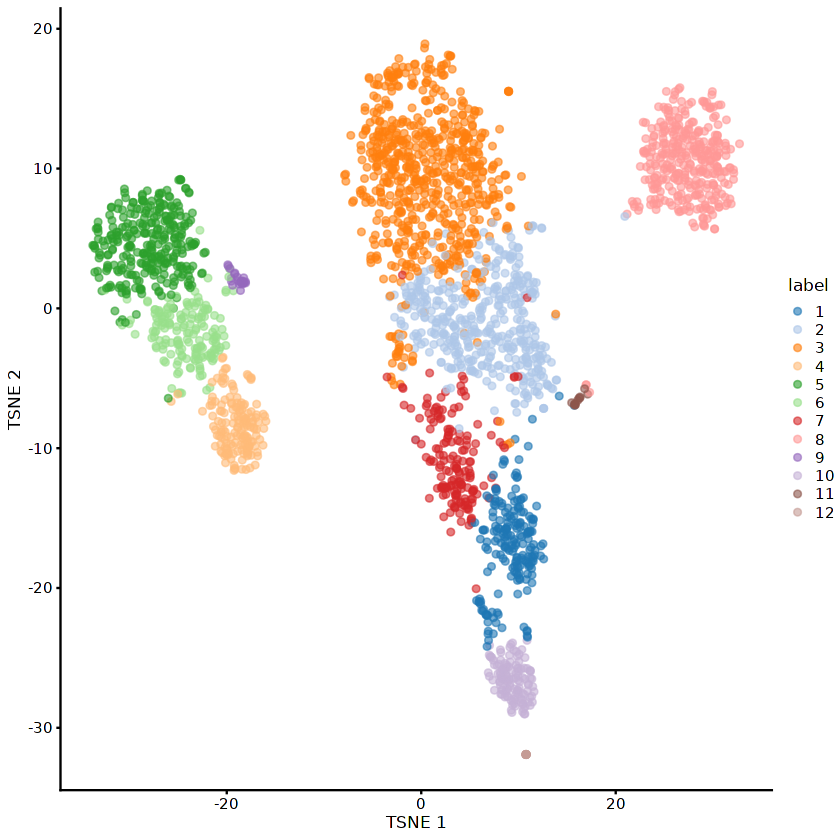

In [86]:
plotTSNE(sce, colour_by="label")

In [87]:
markers <- findMarkers(sce, pval.type="some", direction="up")

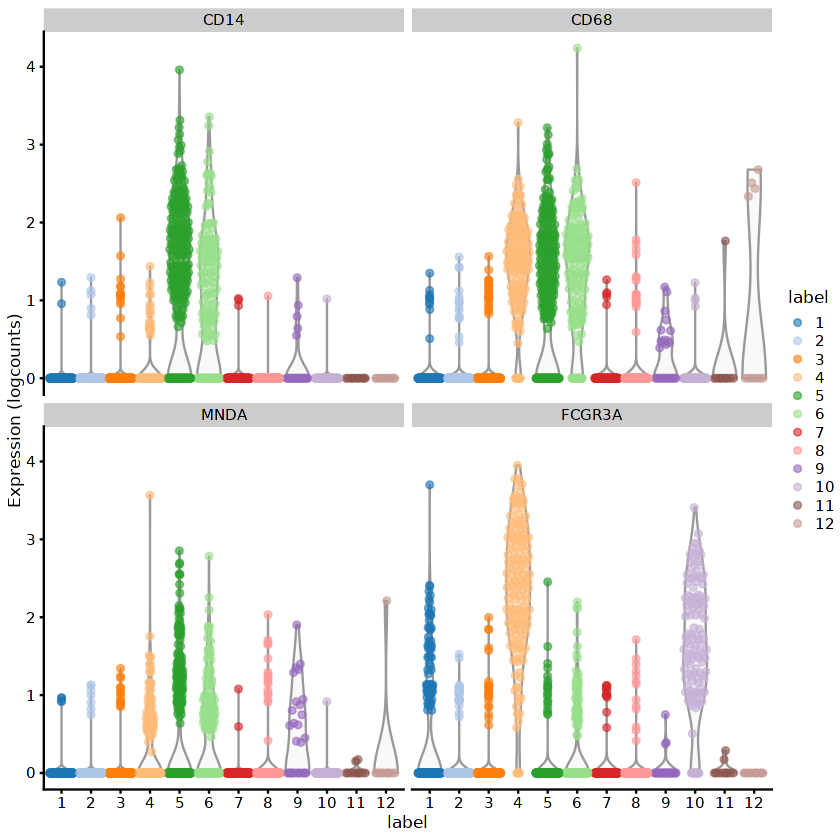

In [88]:
plotExpression(sce, features=c("CD14", "CD68",
    "MNDA", "FCGR3A"), x="label", colour_by="label")